In [2]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

import warnings
warnings.filterwarnings('ignore')

# ALS do not take into account interaction between features of interactions
# Мы получим векторы для id but not for features

In [3]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [4]:
DATA_PATH = Path("kion_train")
!pwd

/home/iuliiasolomennikova/!!!RecSysService/notebooks


# LOAD DATA

In [5]:
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

In [6]:
Columns.Datetime = 'last_watch_dt'

In [7]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [8]:
interactions[Columns.Datetime].str.len().value_counts()

10    5476251
Name: last_watch_dt, dtype: int64

In [9]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

# Train/Test split

In [10]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [11]:
max_date = interactions[Columns.Datetime].max()

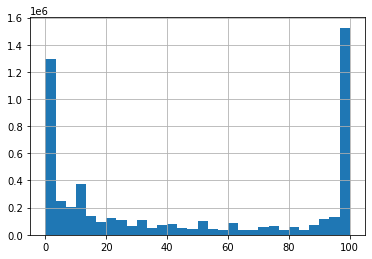

In [12]:
interactions['watched_pct'].hist(bins=30);

In [13]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 15, 3, 1)

In [14]:

train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [15]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [16]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [17]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# MODELS

In [18]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = (32, 64, 128, 160)    # кол-во факторов - размерномть вектора
ITERATIONS = (15, 20)

In [19]:
dataset = Dataset.construct(
    interactions_df=train)
# переиспользуем id

In [20]:
models = {}

In [22]:
implicit_models = {
    'ALS': AlternatingLeastSquares,
}

# используем обертку ImplicitALSWrapperModel
# учим предствления
for implicit_name, implicit_model in implicit_models.items():
    for n_factors in N_FACTORS:
        for iterations in ITERATIONS:
            models[f"{implicit_name}_{n_factors}_{iterations}"] = ImplicitALSWrapperModel(
                model=implicit_model(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                )
            )

In [23]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}


for metric_name, metric in metrics_name.items():
    for k in range(1, 10+1):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [24]:
models

{'ALS_32_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824820>,
 'ALS_32_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824b20>,
 'ALS_64_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824be0>,
 'ALS_64_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824af0>,
 'ALS_128_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824cd0>,
 'ALS_128_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824d30>,
 'ALS_160_15': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824d60>,
 'ALS_160_20': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7f52ae824df0>}

In [25]:
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

In [31]:
results = []
for model_name, model in tqdm(models.items()):
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=test[Columns.User].unique(),
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

100%|██████████| 8/8 [39:17<00:00, 294.72s/it]


In [32]:
df_quality = pd.DataFrame(results).T
# build dataframe with results

df_quality.columns = df_quality.iloc[0]

df_quality.drop('model', inplace=True)

In [33]:
df_quality.style.highlight_max(color='lightgreen', axis=1)
# the best - ALS_32_20

model,ALS_32_15,ALS_32_20,ALS_64_15,ALS_64_20,ALS_128_15,ALS_128_20,ALS_160_15,ALS_160_20
Precision@1,0.030697,0.031201,0.027377,0.027767,0.027439,0.028138,0.026979,0.026572
Recall@1,0.012572,0.012902,0.010826,0.011018,0.011011,0.011250,0.010780,0.010539
Precision@2,0.026470,0.026886,0.024877,0.025182,0.024483,0.024576,0.023704,0.023686
Recall@2,0.021383,0.021842,0.019502,0.019719,0.019094,0.019145,0.018586,0.018528
Precision@3,0.024707,0.025203,0.023031,0.023158,0.021904,0.022199,0.021305,0.021276
Recall@3,0.030066,0.030703,0.026613,0.026771,0.025271,0.025757,0.024732,0.024719
Precision@4,0.023432,0.023609,0.021500,0.021881,0.020256,0.020409,0.019531,0.019612
Recall@4,0.037796,0.038151,0.032682,0.033404,0.031101,0.031182,0.029913,0.029834
Precision@5,0.022201,0.022459,0.020247,0.020487,0.019045,0.019094,0.018156,0.018301
Recall@5,0.044476,0.045252,0.038456,0.038802,0.036275,0.036340,0.034366,0.034473


In [34]:
recos

,user_id,item_id,score,rank
0,203219,4882,0.017602,1
1,203219,13936,0.012512,2
2,203219,965,0.008202,3
3,203219,14213,0.006797,4
4,203219,6311,0.005840,5
...,...,...,...,...
1129765,857162,5087,0.045820,6
1129766,857162,8741,0.044916,7
1129767,857162,7082,0.042962,8
1129768,857162,9103,0.041565,9


In [35]:
# The best model!!! - with best parameters

K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
n_factors = (32)
iterations = (20)

dataset = Dataset.construct(
    interactions_df=train
)

model = ImplicitALSWrapperModel(
                model=AlternatingLeastSquares(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                ))

model.fit(dataset)
recos = model.recommend(
    users=test[Columns.User].unique(),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

In [48]:
recos
!pwd

/home/iuliiasolomennikova/!!!RecSysService/notebooks


In [49]:
# Save recomendations

recos.to_csv('/home/iuliiasolomennikova/!!!RecSysService/notebooks/offline_recommend_df/als', encoding='utf-8', index=False)

In [50]:
def create_dates(start, end, n=15):
    ndays = (end - start).days + 1
    range_ = np.random.randint(0, ndays, n)
    res_dates = pd.to_timedelta(range_, unit='D') + start
    return res_dates

# TEST USERS - AVATARS

In [51]:
N_watched = 15

# User, who watch only movies for child
random_items = np.random.choice(
    np.array(items[items.for_kids == 1].item_id),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-1,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
total_dur = np.random.uniform(7000, 15000, size=N_watched).astype('int')
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_1 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only one genre's movies
random_items = np.random.choice(
    np.array(items[Columns.Item][items['genres'].apply(lambda x: 'боевики' in x)].unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-2,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_2 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

# User, who watch only russian movies with age_rating > 18
random_items = np.random.choice(
    np.array(items[(items.countries == 'Россия') & (items.age_rating == 18.0)].item_id.unique()),
    N_watched,
    replace=False,
)
user_id = np.full(
  shape=N_watched,
  fill_value=-3,
  dtype=np.int
)
last_watch_dt = create_dates(pd.to_datetime(interactions[Columns.Datetime].min()), pd.to_datetime((interactions[Columns.Datetime].max())), N_watched)
watched_pct = np.random.uniform(30, 100, size=N_watched).astype('int').astype('float64')
weight = np.full(
  shape=N_watched,
  fill_value=3,
  dtype=np.int
)
test_user_3 = pd.DataFrame(
    {'user_id': user_id,
     'item_id': random_items,
     'last_watch_dt': last_watch_dt,
     'total_dur': total_dur,
     'watched_pct': watched_pct,
     'weight': weight,
    })

In [52]:
# The best model!!!

K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
n_factors = (32)
iterations = (20)

dataset = Dataset.construct(
    interactions_df=pd.concat([train, test_user_1, test_user_2, test_user_3])
)

model = ImplicitALSWrapperModel(
                model=AlternatingLeastSquares(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                    num_threads=NUM_THREADS,
                    iterations=iterations,
                ))

model.fit(dataset)
recos = model.recommend(
    users=np.append(test[Columns.User].unique(), np.array([-1, -2, -3])),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

In [53]:
items[items.item_id.isin(recos[recos.user_id == -1].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
488,15399,series,Бывшие,NaN,2021.0,"драмы, мелодрамы",Россия,0.0,18.0,NaN,Иван Китаев,"Любовь Аксёнова, Денис Шведов, Полина Гагарина...",Яна выходит замуж за эксцентричного бизнесмена...,"Бывшие, 2021, Россия"
1508,16228,series,Содержанки,NaN,2021.0,триллеры,Россия,0.0,18.0,NaN,"Константин Богомолов, Дарья Жук, Юрий Мороз","Дарья Мороз, Софья Эрнст, Сергей Бурунов, Влад...","Тонкое исследование того, как и чем живёт стол...","Содержанки, 2021, Россия"
5065,14461,film,Пара из будущего,NaN,2021.0,"мелодрамы, комедии",Россия,0.0,12.0,NaN,Алексей Нужный,"Сергей Бурунов, Мария Аронова, Денис Парамонов...","2040-й год. Супруги, которые долгие годы несча...","Пара, из, будущего, 2021, Россия"
7338,1554,film,Последний богатырь: Корень зла,NaN,2021.0,"семейное, фэнтези, приключения, комедии",Россия,0.0,6.0,NaN,Дмитрий Дьяченко,"Виктор Хориняк, Мила Сивацкая, Екатерина Вилко...",Тёмные силы повержены. В Белогорье наконец нас...,"Последний, богатырь, Корень, зла, 2021, Россия"
8275,2954,film,Миньоны,Minions,2015.0,"фантастика, мультфильм, приключения, комедии",США,NaN,6.0,NaN,"Кайл Балда, Пьер Коффан","Сандра Буллок, Джон Хэмм, Майкл Китон, Эллисон...",Миньоны живут на планете гораздо дольше нас. У...,"помощник, сцена после титров, сцена во время т..."
8754,12743,film,Ледниковый период 4: Континентальный дрейф,Ice Age: Continental Drift,2012.0,"мультфильм, приключения, комедии",США,NaN,0.0,NaN,"Стив Мартино, Майк Тёрмайер","Рэй Романо, Джон Легуизамо, Куин Латифа, Дэнис...",После приключений под землей прошло семь лет. ...,"тюлень (животное), доисторические времена, таю..."
9806,1131,series,Вампиры средней полосы,NaN,2021.0,"детективы, комедии",Россия,0.0,18.0,NaN,Антон Маслов,"Юрий Стоянов, Татьяна Догилева, Екатерина Кузн...","Наши вампиры — разумные, добрые, вечные. Лишь ...","Вампиры, средней, полосы, 2021, Россия"
10506,3071,film,Родные,NaN,2021.0,"драмы, комедии",Россия,0.0,12.0,NaN,Илья Аксёнов,"Сергей Бурунов, Ирина Пегова, Сергей Шакуров, ...","Комедия с Сергеем Буруновым, Ириной Пеговой и ...","Родные, 2021, Россия"
12620,13243,film,Головоломка,Inside Out,2015.0,"фантастика, мультфильм, комедии",США,NaN,6.0,NaN,"Пит Доктер, Роналдо Дель Кармен","Эми Полер, Филлис Смит, Ричард Кайнд, Билл Хей...",11-летняя девочка Райли переезжает с семьёй из...,"мечта, мультфильм, воображаемый друг, начальна..."
12962,6382,series,Медиатор,NaN,2021.0,"драмы, триллеры, детективы",Россия,0.0,18.0,NaN,Артём Аксёненко,"Андрей Бурковский, Юлия Пересильд, Дарья Мороз...","Психологический триллер с Андреем Бурковским, ...","Медиатор, 2021, Россия"


In [54]:
items[items.item_id.isin(recos[recos.user_id == -2].item_id)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
154,12057,film,Пираты карибского моря: На странных берегах,Pirates of the Caribbean: On Stranger Tides,2011.0,"боевики, фэнтези, приключения","США, Великобритания",NaN,12.0,NaN,Роб Маршалл,"Джонни Депп, Пенелопа Крус, Джеффри Раш, Иэн М...","В новой истории о поисках истины, предательств...","море, капитан, мятеж, меч, премьер-министр, пл..."
5781,12623,film,Пираты карибского моря: Проклятие чёрной жемчу...,Pirates of the Caribbean: The Curse of the Bla...,2003.0,"боевики, фэнтези, приключения",США,NaN,12.0,NaN,Гор Вербински,"Джонни Депп, Джеффри Раш, Орландо Блум, Кира Н...","Жизнь харизматичного авантюриста, капитана Дже...","экзотический остров, кузнец, торговая компания..."
8107,2722,film,Один дома,Home Alone,1990.0,"семейное, комедии",США,NaN,12.0,NaN,Крис Коламбус,"Маколей Калкин, Джо Пеши, Дэниел Стерн, Кэтрин...",Американское семейство отправляется из Чикаго ...,"праздник, грабитель, маленький мальчик, вторже..."
8429,8350,film,Перевозчик,The Transporter,2002.0,"боевики, триллеры, криминал","Франция, США",NaN,16.0,NaN,"Луи Летерье, Кори Юэнь","Джейсон Стэйтем, Шу Ци, Франсуа Берлеан, Мэтт ...",Бывший десантник Фрэнк Мартин имеет неплохой б...,"боевые искусства, автомобильное путешествие, т..."
9253,1844,film,Аферистка,I Care A Lot,2020.0,"триллеры, комедии",Великобритания,NaN,18.0,NaN,Джей Блейксон,"Розамунд Пайк, Питер Динклэйдж, Эйса Гонсалес,...",Марла руководствуется принципом «побеждает сил...,"опекун, аферист, чёрная комедия, мошенник, 202..."
9938,14431,film,Приворот. Чёрное венчание,Privorot. Chernoe venchanie,2021.0,"ужасы, триллеры, мелодрамы",Россия,NaN,16.0,NaN,Святослав Подгаевский,"Яна Енжаева, Константин Белошапка, Илья Ермоло...",Отечественный хоррор с любовной историей. Женю...,", 2021, россия, приворот, чёрное, венчание"
11888,4685,film,1+1,Intouchables,2011.0,"драмы, биография, комедии",Франция,NaN,16.0,NaN,"Оливье Накаш, Эрик Толедано","Франсуа Клюзе, Омар Си, Анн Ле Ни, Одри Флеро,...","Пострадав в результате несчастного случая, бог...","мужская дружба, массажистка, дружба, основано ..."
12539,1553,film,Пираты карибского моря: На краю света,Pirates of the Caribbean: At World's End,2007.0,"боевики, фэнтези, приключения",США,NaN,12.0,NaN,Гор Вербински,"Джонни Депп, Джеффри Раш, Орландо Блум, Кира Н...",Новые приключения Джека Воробья и его друзей У...,"экзотический остров, торговая компания Восточн..."
12540,14264,film,Пираты Карибского Моря: Сундук Мертвеца,Pirates of the Caribbean: Dead Man's Chest,2006.0,"боевики, фэнтези, приключения",США,NaN,12.0,NaN,Гор Вербински,"Джонни Депп, Орландо Блум, Кира Найтли, Джек Д...","Вновь оказавшись в ирреальном мире, лихой капи...","ведьма, гадалка, неволя, экзотический остров, ..."
13880,1819,film,Непосредственно Каха,Neposredstvenno Kakha,2020.0,комедии,Россия,NaN,16.0,NaN,Виктор Шамиров,"Артем Карокозян, Артем Калайджян, Марина Калец...",Южнороссийская хитовая комедия по мотивам попу...,"2020, россия, непосредственно, каха"


In [56]:
!pwd

/home/iuliiasolomennikova/!!!RecSysService/notebooks
